
# Задание:
----

<br>

Вам предоставлен анонимизированные результаты **реального A/B тестирования**, проходившего когда-то в нашем отделе (`ab_test_ensembles.csv`). В тесте было два варианта работы сервиса - `standard` и `svm_ensemble_v_1_22`, где работали несколько моделей классификации для целей сервиса.

<br>


------
Вам, как специалистам по машинному обучению предстоит ответить на **2 главных вопроса:**

1. Стоит ли нам оставить старый вариант работы сервиса или заменить его на вариант работы с моделями классификации (используем всю выборку 200к+ пользователей).
2. Кроме того, посчитайте вывод для типа пользователей (`user_type`). Стоит ли для новых (старых) пользователей оставить старый (новый) вариант работы сервиса.


<br>

Для того, чтобы освежить в памяти процесс тестирования статистических гипотез, непомню, что тестирование состоит из следующих частей:
1. Дизайн эксперимента.
2. Подготовка и запуск эксперимента.
3. Сбор данных и аналитика полученных данных.
4. Визуализация результатов тестирования.
5. Тестирование гипотез.
6. Вывод и интерпритация результатов.

-----

#### Критерии оценки задания:

1. **Первое, что будет проверяться - вывод полученных результатов**, в случае если выводы сделаны не правильно, задание считается проваленным и на этом этап проверки заканчивается (пропускаются этапы код-ревью, оформления и визуализации, качество кода).
2. В случае если результаты и интерпритация результатов оказались верны, проводится код-ревью и проверка этапа визуализаций, поиск проблемных точек, точек роста.
3. **Максимальный балл** который можно получить, выполнив текущее задание: **2 балла за 1 вопрос, 2 балла за 2 вопрос и 1 балл за эффективный и аккуратный код.


Удачи, примените все свои навыки, которые вам доступны на данный момент и покажите на что вы способны!

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import stats, norm, binom, beta, normaltest, probplot
import statsmodels.api as sm
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv("./ab_test_ensembles.csv", index_col=False, parse_dates=['timestamp'])
pd.set_option('display.max_columns', len(df.columns))
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    294478 non-null  object        
 1   timestamp  294478 non-null  datetime64[ns]
 2   group      294478 non-null  object        
 3   variants   294478 non-null  object        
 4   converted  294478 non-null  int64         
 5   location   294478 non-null  object        
 6   age_group  294478 non-null  object        
 7   user_type  294478 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 18.0+ MB


In [11]:
print(df.group.unique().tolist())
print(df.variants.unique().tolist())
print(df.converted.unique().tolist())
print(df.location.unique().tolist())
print(df.age_group.unique().tolist())
print(df.user_type.unique().tolist())

['control', 'treatment']
['standard', 'svm_ensemble_v_1_22']
[0, 1]
['United Kingdom']
['18-25', '42-49', '26-33', '58+', '34-41', '50-57']
['registered_user', 'new_user']


In [16]:
print(df.group.value_counts())
print(df.group.value_counts(normalize=True))

group
treatment    147276
control      147202
Name: count, dtype: int64
group
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64


In [17]:
print(df.variants.value_counts())
print(df.variants.value_counts(normalize=True))

variants
standard               147239
svm_ensemble_v_1_22    147239
Name: count, dtype: int64
variants
standard               0.5
svm_ensemble_v_1_22    0.5
Name: proportion, dtype: float64


Для тестирования новой работы сервиса у нас разбивка на две абсолютно равные части.

In [18]:
print(df.user_type.value_counts())
print(df.user_type.value_counts(normalize=True))

user_type
registered_user    147240
new_user           147238
Name: count, dtype: int64
user_type
registered_user    0.500003
new_user           0.499997
Name: proportion, dtype: float64


In [26]:
df['variants'] = np.where(df['variants'] == 'standard', 'A', 'B')

Mann-Whitney U Test

In [45]:
converted_A = df[df.variants=='A'].converted
converted_B = df[df.variants=='B'].converted

def mannwhitneyfunc(value1,value2):
    stat, p=mannwhitneyu(value1,value2)
    alpha=0.05

    print('p=%.4f , alpha=%.2f \n'%(p,alpha))
    if p > alpha:
        print('Fail to reject H0; Two version have no significant difference')
    else:
        print('Have enough envidence to reject H0; Two version have a significant difference')

mannwhitneyfunc(converted_A,converted_B)

p=0.1712 , alpha=0.05 

Fail to reject H0; Two version have no significant difference


Статистической значимости между вариантами нет, поэтому новый вариант работы сервиса не принимаем.

Протестируем с помощью **Bootstrapping**

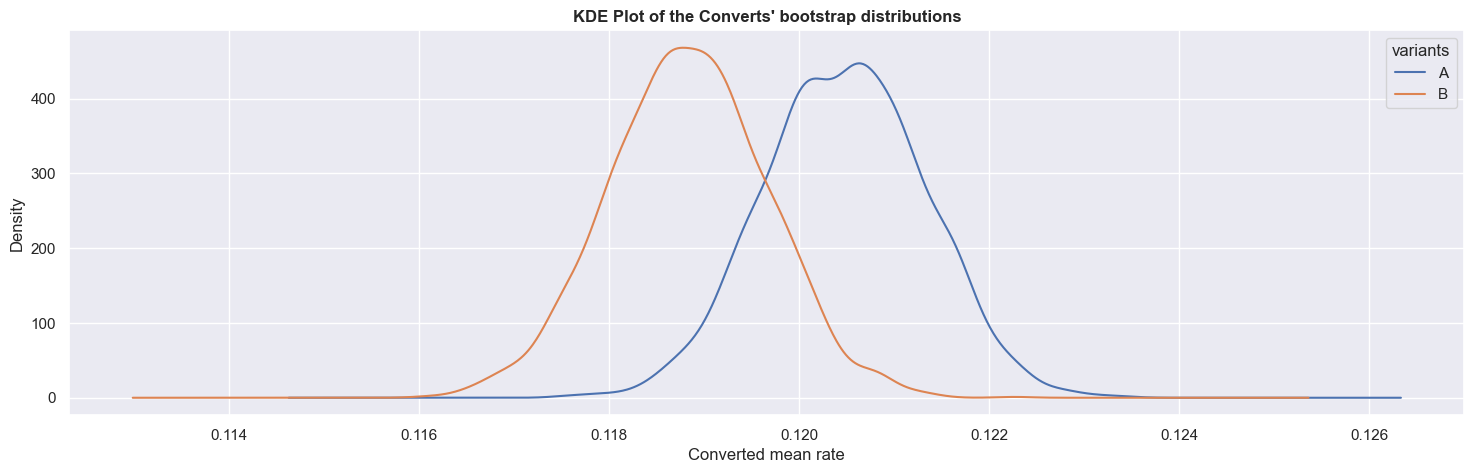

In [40]:
n = 2000

bootstrap_mean = pd.DataFrame([df.sample(frac=1, replace=True).groupby('variants')['converted'].mean() for i in range(n)])

bootstrap_mean.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the Converts' bootstrap distributions", fontweight="bold")
plt.xlabel("Converted mean rate")
plt.show()

In [42]:
alpha = 0.05

bootstrap_mean['diff_mean'] = bootstrap_mean['B'] - bootstrap_mean['A']
mean_pos_count = len(bootstrap_mean[bootstrap_mean['diff_mean'] > 0])
p_mean_diff = mean_pos_count/n
print(p_mean_diff)
p_mean_diff > alpha

0.0875


True

Все еще не хватает статистической значимости. Не принимаем новый вариант работы.

Проверим для новых и старых пользователей.

Mann-Whitney U Test для новых пользователей.

In [62]:
converted_A_new = df[(df.variants=='A') & (df.user_type=='new_user')].converted
converted_B_new = df[(df.variants=='B') & (df.user_type=='new_user')].converted

mannwhitneyfunc(converted_A_new,converted_B_new)

p=0.0225 , alpha=0.05 

Have enough envidence to reject H0; Two version have a significant difference


**Bootstrapping** для новых пользователей.

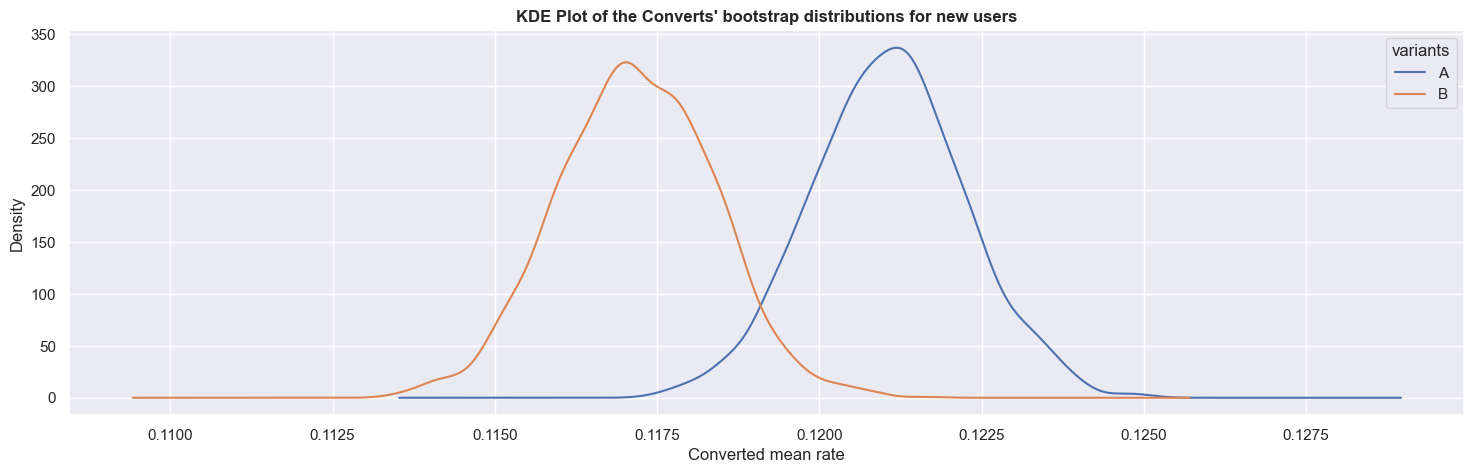

In [67]:
n = 2000

df_new = df[df.user_type=='new_user'].copy()
bootstrap_mean_new = pd.DataFrame([df_new.sample(frac=1, replace=True).groupby('variants')['converted'].mean() for i in range(n)])

bootstrap_mean_new.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the Converts' bootstrap distributions for new users", fontweight="bold")
plt.xlabel("Converted mean rate")
plt.show()

In [68]:
bootstrap_mean_new['diff_mean'] = bootstrap_mean_new['B'] - bootstrap_mean_new['A']
mean_pos_count_new = len(bootstrap_mean_new[bootstrap_mean_new['diff_mean'] > 0])
p_mean_diff_new = mean_pos_count_new/n
print(p_mean_diff_new)
p_mean_diff_new > alpha

0.009


False

Для новых пользователей статистическая значимость есть и можно принимать новый вариант работы сервиса.

Mann-Whitney U Test для старых пользователей.

In [71]:
converted_A_new = df[(df.variants=='A') & (df.user_type=='registered_user')].converted
converted_B_new = df[(df.variants=='B') & (df.user_type=='registered_user')].converted

mannwhitneyfunc(converted_A_new,converted_B_new)

p=0.7351 , alpha=0.05 

Fail to reject H0; Two version have no significant difference


**Bootstrapping** для старых пользователей.

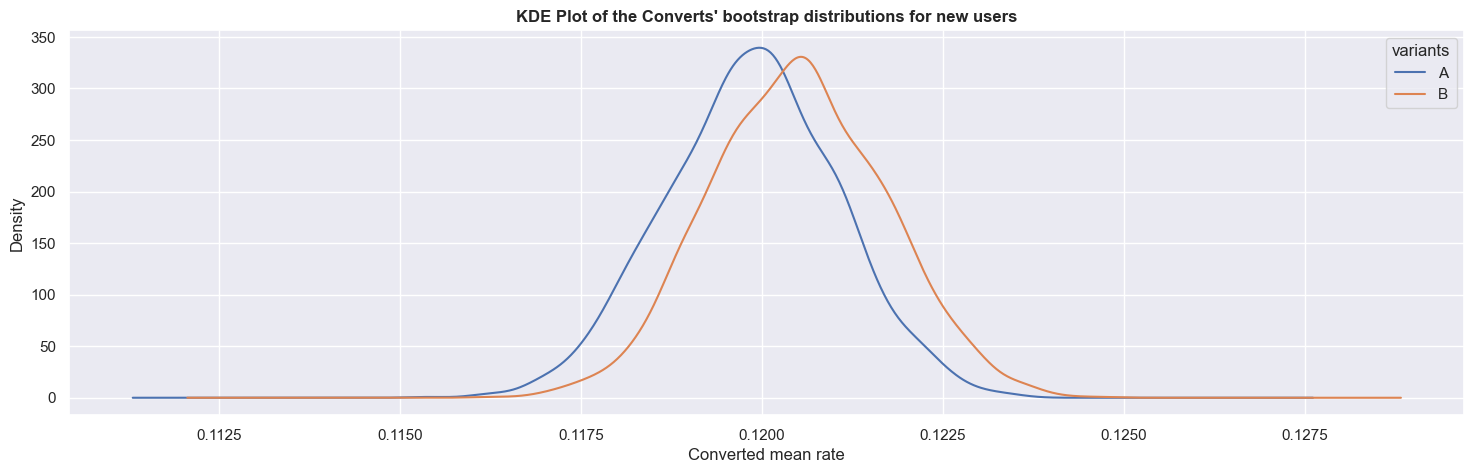

In [72]:
n = 2000

df_registered = df[df.user_type=='registered_user'].copy()
bootstrap_mean_registered = pd.DataFrame([df_registered.sample(frac=1, replace=True).groupby('variants')['converted'].mean() for i in range(n)])

bootstrap_mean_registered.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the Converts' bootstrap distributions for new users", fontweight="bold")
plt.xlabel("Converted mean rate")
plt.show()

In [73]:
bootstrap_mean_registered['diff_mean'] = bootstrap_mean_registered['B'] - bootstrap_mean_registered['A']
mean_pos_count_registered = len(bootstrap_mean_registered[bootstrap_mean_registered['diff_mean'] > 0])
p_mean_diff_registered = mean_pos_count_registered/n
print(p_mean_diff_registered)
p_mean_diff_registered > alpha

0.636


True

Для старых пользователей оставляем старый вариант.

Новый вариант работы сервиса можно запускать для новых пользоваетелей. Для старых статистической значимости нет.